In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import torch

import matplotlib.pyplot as plt

from my_dlp.dataset import Dataset
from my_dlp.visualizer import Visualizer, SemanticVisualizer
from PIL import Image

from parksim.intent_predict.cnn.data_processing.utils import CNNDataProcessor
from parksim.trajectory_predict.data_processing.utils import TransformerDataProcessor

from parksim.intent_predict.cnn.models.small_regularized_cnn import SmallRegularizedCNN
from parksim.trajectory_predict.intent_transformer.models.trajectory_predictor_vision_transformer import TrajectoryPredictorVisionTransformer
from parksim.trajectory_predict.intent_transformer.models.trajectory_predictor_with_decoder_intent_cross_attention import TrajectoryPredictorWithDecoderIntentCrossAttention

from parksim.trajectory_predict.intent_transformer.multimodal_prediction import predict_multimodal

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
ds = Dataset()

home_path = str(Path.home()) 
ds.load(home_path + '/dlp-dataset/data/DJI_0012')

In [3]:
MODEL_PATH = '/home/azero/ParkSim/python/parksim/data/epoch=52-val_total_loss=0.0458.ckpt'
traj_model = TrajectoryPredictorWithDecoderIntentCrossAttention.load_from_checkpoint(MODEL_PATH)
traj_model.eval().to(DEVICE)
mode='v1'

INTENT_MODEL_PATH = '/home/azero/ParkSim/python/parksim/data/smallRegularizedCNN_L0.068_01-29-2022_19-50-35.pth'
intent_model = SmallRegularizedCNN()
model_state = torch.load(INTENT_MODEL_PATH, map_location=DEVICE)
intent_model.load_state_dict(model_state)
intent_model.eval().to(DEVICE)

Lightning automatically upgraded your loaded checkpoint from v1.6.1 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../data/epoch=52-val_total_loss=0.0458.ckpt`


SmallRegularizedCNN(
  (image_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(

In [4]:
intent_extractor = CNNDataProcessor(ds=ds)
traj_extractor = TransformerDataProcessor(ds=ds)

In [5]:
def draw_prediction(multimodal_prediction, inst_centric_view, colors, intent_offsets, save_image_name="test.png"):
    sensing_limit = 20
    img_size = inst_centric_view.size[0] / 2

    plt.cla()

    plt.imshow(inst_centric_view)

    y_label, _, _, _ = multimodal_prediction[0]

    traj_future_pixel = y_label[0, :, :2].detach().cpu().numpy() / \
        sensing_limit*img_size + img_size

    plt.plot(traj_future_pixel[:, 0], traj_future_pixel[:, 1], 'wo', linewidth=2, markersize=2)

    for prediction, color, offset in zip(reversed(multimodal_prediction), reversed(colors), reversed(intent_offsets)):

        _, pred, intent, probability = prediction

        intent_pixel = intent[0, 0, :2].detach().cpu().numpy() / \
            sensing_limit*img_size + img_size

        traj_pred_pixel = pred[0, :, :2].detach().cpu().numpy() / \
            sensing_limit*img_size + img_size

        plt.plot(traj_pred_pixel[:, 0], traj_pred_pixel[:, 1],
                 '^', color=color, linewidth=2, markersize=2)
        plt.plot(intent_pixel[0], intent_pixel[1],
                 '*', color=color, markersize=8)

        plt.text(intent_pixel[0]+offset[0], intent_pixel[1]+offset[1],
                 f'{probability:.2f}', backgroundcolor=(170/255., 170/255., 170/255., 0.53), color='black', size=7, weight='bold')
        print(color, probability)
    # 保存图片
    plt.savefig("/home/azero/ParkSim/python/parksim/data/temp" + save_image_name)
    plt.axis('off')


green 0.21372929
green 0.2533318
green 0.2580707
green 0.23634303
green 0.21095708
green 0.20928831
green 0.17237982
green 0.15176608
green 0.14641793
green 0.16496524
green 0.1796501
green 0.16070043
green 0.16740306
green 0.1679374
green 0.18767563
green 0.17983845
green 0.15948884
green 0.15477735
green 0.16783817
green 0.20538883
green 0.22484358
green 0.26294044
green 0.23070052
green 0.20575553
green 0.23419614
green 0.25062218


KeyboardInterrupt: 

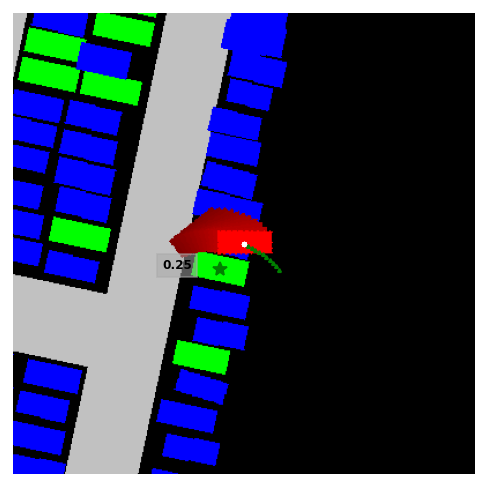

In [6]:
import os
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50,0], [0,30], [-50,0]]
os.makedirs(f'/home/azero/ParkSim/python/parksim/data/temp/test', exist_ok=True)
smt_vis = SemanticVisualizer(ds, spot_margin=0.3, resolution=0.1, sensing_limit=20, steps=10, stride=10)
scene = ds.get('scene', ds.list_scenes()[0])
for i in range(1000):
    frame_token = scene['last_frame']
    frame = ds.get('frame', frame_token)
    for inst_token in frame['instances']:
        multimodal_prediction, inst_centric_view = predict_multimodal(
            ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, len(ds.frames.keys())-1, 1, mode=mode, is_get_trajectory_future=False)
        ds.append_agent_pred_dpose(inst_token, multimodal_prediction[0][1][0][0].detach().cpu().numpy())
        instance = ds.get('instance', inst_token)
        agent_token = instance['agent_token']
        draw_prediction(multimodal_prediction, inst_centric_view, colors, intent_offsets, save_image_name=f'{agent_token}_{i}.png')
    ds.update()
    img_frame = smt_vis.plot_frame(frame['frame_token'])
    img_frame.transpose(Image.FLIP_TOP_BOTTOM).save(f'/home/azero/ParkSim/python/parksim/data/temp/test/{i}.png')

# Example 1

In [ ]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = -1
frame = ds.get_future_frames(scene['first_frame'],timesteps=100)[frame_index]
inst_token = frame['instances'][9]
print(frame)

In [ ]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 1, mode=mode)


In [ ]:
print(multimodal_prediction[0][1][0][0].detach().cpu().numpy())

In [ ]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50,0], [0,30], [-50,0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 2

In [ ]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 2500
frame = ds.get_future_frames(scene['first_frame'], timesteps=2700)[frame_index]
inst_token = frame['instances'][33]


In [ ]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


In [ ]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 3

In [ ]:
# scene = ds.get('scene', ds.list_scenes()[0])
# frame_index = 5900
# frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
# inst_token = frame['instances'][37]

scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 5900
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][20]


In [ ]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


In [ ]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 4

In [ ]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 4000
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][36]


In [ ]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


In [ ]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 5

In [ ]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 100
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][6]


In [ ]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


In [ ]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 6

In [ ]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 1800
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[70, 30])[
    'instance_token']


In [ ]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


In [ ]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, 30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 7

In [ ]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 7010
frame = ds.get_future_frames(scene['first_frame'], timesteps=7100)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[15, 30])[
    'instance_token']


In [ ]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


In [ ]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, -30], [10, 30]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 8

In [ ]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 9000
frame = ds.get_future_frames(scene['first_frame'], timesteps=9001)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[35, 65])[
    'instance_token']


In [ ]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


In [ ]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, -20], [-30, -20]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)
